# Importing libraries

In [1]:
import math
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import random
from sklearn.cluster import KMeans
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics.cluster import adjusted_rand_score, adjusted_mutual_info_score, fowlkes_mallows_score
from sklearn.metrics import silhouette_score, davies_bouldin_score, calinski_harabasz_score
import seaborn as sns
from sklearn.manifold import TSNE
from sklearn.decomposition import NMF
import tensorflow as tf
from sklearn.metrics.pairwise import euclidean_distances

In [2]:
!pip install pytictoc

In [3]:
!pip install kneed

In [4]:
from pytictoc import TicToc
t = TicToc()

# Importing scRNA-seq data

In [5]:
#Mounting google drive
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [6]:
ls "/content/drive/My Drive/scRNAseq Data/Preprocessed_Data_Annotations/"

AMB_annotations.csv
AMB_preprocessed_data_scprep_percentile_5_95.csv
Baron_Human_annotations.csv
Baron_Human_preprocessed_data_scprep_percentile_5_95.csv
Baron_Mouse_annotations.csv
Baron_Mouse_preprocessed_data_scprep_percentile_5_95.csv
GSE57249_fpkm_labels.csv
GSE57249_fpkm_preprocessed.csv
missingAnnotations_Test.csv
PBMC_3k_annotations.csv
PBMC3K_preprocessed_data_minmax_normalized.csv
PBMC_3k_preprocessed_data_scanpy.csv
Preimplantation_annotations.csv
Preimplantation_preprocessed_data_scprep_percentile_20_90.csv
Segerstolpe_annotations.csv
Segerstolpe_preprocessed_data_scprep_percentile_10_95.csv
Usoskin_annotations.csv
Usoskin_preprocessed_data_scprep_percentile_5_95.csv
Zeisel_annotations.csv
Zeisel_preprocessed_data_scprep_percentile_5_95.csv
Zheng_PBMC_DownSampled_annotations.csv
Zheng_PBMC_DownSampled_preprocessed_data_scprep_percentile_5_90.csv


In [7]:
data = pd.read_csv("/content/drive/My Drive/scRNAseq Data/Preprocessed_Data_Annotations/Segerstolpe_preprocessed_data_scprep_percentile_10_95.csv", header=0, index_col=0, sep=",")

In [8]:
labels = pd.read_csv("/content/drive/My Drive/scRNAseq Data/Preprocessed_Data_Annotations/Segerstolpe_annotations.csv", header=0, index_col=None, sep=",")

In [9]:
data.reset_index(inplace=True, drop=True)

In [10]:
data.head()

,CLIC4,TGFBR3,PRUNE,EYA3,STMN1,PTPRF,RAB3B,LEPR,DDAH1,GNAI3,RHOC,NOTCH2,SOAT1,EPRS,C1orf127,AGTRAP,SH3BGRL3,CMPK1,TTC39A,PPAP2B,PGM1,JAK1,WLS,GNG12,PRKACB,VCAM1,VAV3,KIAA1324,TSPAN2,ATP1A1,VTCN1,CTSS,IL6R,LMNA,SYT11,IFI16,RGS5,RXRG,ATP1B1,PAPPA2,...,CECR1,ADRBK2,SEZ6L,HMOX1,RPL3,PACSIN2,PLXNB2,SLC25A1,CLDN5,GGT1,TPST2,XBP1,LIF,SELM,PIK3IP1,PISD,RTCB,TIMP3,RAC2,CDC42EP1,LGALS2,LGALS1,H1F0,KDELR3,ATF4,TSPO,PIM3,ERCC_30000:mix1_7500:mix2,ERCC_7500:mix1_1875:mix2,ERCC_1875:mix1_468.75:mix2,ERCC_937.5:mix1_234.375:mix2,ERCC_468.75:mix1_117.1875:mix2,ERCC_15000:mix1_15000:mix2,ERCC_3750:mix1_3750:mix2,ERCC_937.5:mix1_937.5:mix2,ERCC_15000:mix1_22500:mix2,ERCC_3750:mix1_5625:mix2,ERCC_15000:mix1_30000:mix2,ERCC_937.5:mix1_1875:mix2,ERCC_234.375:mix1_468.75:mix2
0,0.185423,0.000000,0.000000,0.000000,1.229955,1.637609,2.172956,1.048909,0.000000,0.502127,0.0,0.0,1.03239,1.201677,0.0,0.00000,1.521521,0.889256,2.232785,0.000000,0.718139,1.637609,0.355058,1.289099,0.902052,0.0,0.0,2.483096,0.000000,1.918028,0.0,0.0,0.000000,1.192101,1.794550,0.0,0.914669,0.000000,2.914147,0.0,...,1.884878,0.975307,1.054358,0.0,2.364897,0.466637,1.689281,0.000000,0.0,0.0,0.000000,0.000000,0.0,1.547660,0.0,0.793933,1.215898,0.0,0.0,0.0,0.000000,0.0,2.735640,0.0,1.525283,0.302794,0.908382,0.0,0.000000,0.0,0.0,0.000000,0.107054,0.000000,0.0,0.0,0.0,0.0,0.151397,0.0
1,0.000000,0.000000,1.670667,2.068522,1.491443,1.184334,1.481912,0.000000,1.219695,0.000000,0.0,0.0,0.11903,1.254060,0.0,0.00000,1.135475,1.579112,0.000000,0.000000,0.000000,0.119030,0.000000,0.000000,0.000000,0.0,0.0,1.196237,0.291563,1.166252,0.0,0.0,0.000000,0.000000,3.041678,0.0,0.000000,0.000000,3.255424,0.0,...,0.000000,2.359679,0.461002,0.0,2.023511,0.119030,0.000000,0.890740,0.0,0.0,0.000000,0.000000,0.0,0.000000,0.0,1.383005,1.330797,0.0,0.0,0.0,0.000000,0.0,2.201252,0.0,0.858338,0.000000,0.995877,0.0,0.000000,0.0,0.0,0.000000,0.119030,0.119030,0.0,0.0,0.0,0.0,0.000000,0.0
2,0.000000,0.000000,0.000000,1.626815,1.732498,0.000000,2.079618,1.596779,0.000000,2.342371,0.0,0.0,0.00000,2.559642,0.0,0.00000,2.349250,1.136217,1.943230,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.0,4.096688,0.000000,1.616865,0.0,0.0,2.032527,0.000000,0.000000,0.0,0.000000,0.000000,2.236645,0.0,...,0.000000,0.000000,0.000000,0.0,2.272434,2.307667,2.515123,1.959768,0.0,0.0,0.000000,1.270329,0.0,0.000000,0.0,0.538955,0.000000,0.0,0.0,0.0,0.000000,0.0,0.000000,0.0,0.000000,0.000000,1.901255,0.0,0.000000,0.0,0.0,0.179652,0.179652,0.254066,0.0,0.0,0.0,0.0,0.000000,0.0
3,0.161254,0.161254,1.206712,1.259431,1.045043,0.000000,2.127081,0.000000,0.000000,0.926332,0.0,0.0,0.00000,0.161254,0.0,0.00000,1.007029,1.339473,0.000000,0.000000,0.000000,2.524018,0.000000,1.319918,1.007029,0.0,0.0,1.766445,0.000000,1.873598,0.0,0.0,0.000000,0.822235,0.702888,0.0,0.000000,1.788389,2.731810,0.0,...,2.816173,0.000000,0.000000,0.0,1.817236,0.161254,1.195889,1.007029,0.0,0.0,0.000000,1.387156,0.0,0.000000,0.0,2.026927,0.000000,0.0,0.0,0.0,0.000000,0.0,1.529786,0.0,0.994034,0.000000,0.000000,0.0,0.161254,0.0,0.0,0.000000,0.000000,0.000000,0.0,0.0,0.0,0.0,0.000000,0.0
4,0.000000,0.000000,1.705230,1.665843,2.592007,0.000000,1.931586,0.000000,0.000000,0.000000,0.0,0.0,1.45298,1.693510,0.0,1.29344,1.457542,0.000000,2.038605,0.115229,0.000000,0.609733,1.600809,0.907312,0.000000,0.0,0.0,3.351554,0.000000,1.475648,0.0,0.0,0.230458,0.877556,0.000000,0.0,0.000000,0.000000,2.753462,0.0,...,1.588319,2.012384,0.914600,0.0,1.896905,0.000000,0.115229,0.415463,0.0,0.0,0.115229,0.620526,0.0,1.397075,0.0,0.000000,2.411560,0.0,0.0,0.0,0.115229,0.0,1.406547,0.0,0.000000,0.000000,0.000000,0.0,0.000000,0.0,0.0,0.000000,0.162958,0.000000,0.0,0.0,0.0,0.0,0.115229,0.0


# Scaling data (if required)

In [11]:
%%script false
#only for scanpy pre-processed data (PBMC - 10x Genomics)
from sklearn.preprocessing import MinMaxScaler
scaler = MinMaxScaler()
data = pd.DataFrame(scaler.fit_transform(data))
data.head()

# Checking loaded data

In [12]:
data.shape

(1630, 1830)

In [13]:
labels.shape

(1630, 2)

In [14]:
labels.nunique()

Unnamed: 0    1630
x               13
dtype: int64

In [17]:
labels = labels['x']
labels.head()

0    delta
1    alpha
2    delta
3    gamma
4    alpha
Name: x, dtype: object

# Finding the optimal dimensions for embedding using reconstruction error

In [18]:
d = range(2,16)
k=[]
error=[]
# try each value of k
for i in d:
    print("Applying NMF for k=%d ..." % i)
    # run NMF
    model = NMF(init="nndsvd", n_components=i) 
    W = model.fit_transform(data)
    H = model.components_    
    k.append(i)
    error.append(model.reconstruction_err_)

Applying NMF for k=2 ...
Applying NMF for k=3 ...
Applying NMF for k=4 ...
Applying NMF for k=5 ...
Applying NMF for k=6 ...
Applying NMF for k=7 ...
Applying NMF for k=8 ...
Applying NMF for k=9 ...
Applying NMF for k=10 ...
Applying NMF for k=11 ...
Applying NMF for k=12 ...
Applying NMF for k=13 ...
Applying NMF for k=14 ...
Applying NMF for k=15 ...


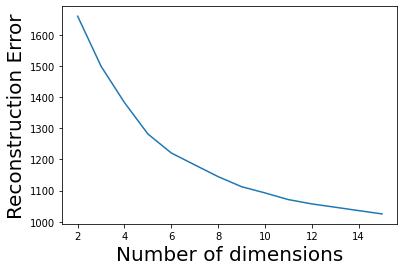

In [19]:
# Plotting a bar graph to compare the results 
plt.plot(k, error) 
plt.xlabel('Number of dimensions', fontsize = 20) 
plt.ylabel('Reconstruction Error', fontsize = 20) 
plt.show() 

In [20]:
x = range(2, len(error)+2)

from kneed import KneeLocator
kn = KneeLocator(x, error, curve='convex', direction='decreasing')
print(kn.knee)

6


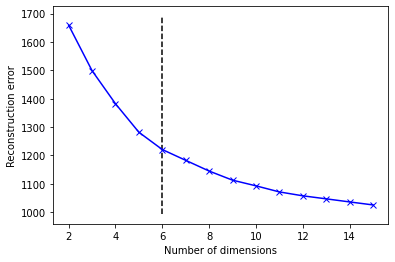

In [21]:
plt.xlabel('Number of dimensions')
plt.ylabel('Reconstruction error')
plt.plot(x, error, 'bx-')
plt.vlines(kn.knee, plt.ylim()[0], plt.ylim()[1], linestyles='dashed')

# Lower dimensional cell embedding using NMF

In [22]:
optDim = kn.knee

In [23]:
#Mark the begining of the proposed method
t.tic()

In [24]:
data_orig = data.copy()

In [25]:
model = NMF(n_components=optDim, init='nndsvd')
W = model.fit_transform(data)
H = model.components_

In [26]:
print(W.shape)
print(H.shape)

(1630, 6)
(6, 1830)


In [27]:
data = pd.DataFrame(W)

# (A) Encoding labels (B) Removing p% labels (C) Labelling unknown cells as -1

**Encoding the labels**

In [28]:
from sklearn import preprocessing
le = preprocessing.LabelEncoder()
y = pd.DataFrame(le.fit_transform(np.ravel(labels)))

In [29]:
y1 = y.copy()

**Removing p% labels (if no label is missing)**

In [30]:
p = 0.9   #input parameter p = {0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8 0.9}
n = int(p * data.shape[0])    
index = random.sample(range(1, data.shape[0]), n)
ground_truth = y.copy()

In [31]:
data.shape

(1630, 6)

In [32]:
dataWOmissingLab = data_orig.iloc[~y.index.isin(index)]
LabNOTmissing = y.iloc[~y.index.isin(index)]

**Labelling unknown data as -1**

In [33]:
y.iloc[index] = -1           # forcibly removing p% of the labels
indx = pd.DataFrame(np.arange(0,data.shape[0]))
df = pd.concat([data,indx], axis=1)
X = pd.concat([df,y], axis=1)

In [34]:
#Setting k to the number of unique labels in the data excluding -1 (-1 stands for unknown labels)
k = y[0].nunique()-1

# Clustering using k-Means

Recursive clustering

In [35]:
def rec_KMeans(res):
    if len(res) == 0:
        return
    
    num_labels = set()
    #finding no. of known labels for each cluster
    for i in res:
        if(i[-1] != -1):
          num_labels.add(i[-1])
    print(len(num_labels), num_labels)   

    if(len(num_labels) == 1):     #if all labelled data belong from one class
        final_clusters.append(res)
        cluster_label.append(num_labels)
        return
    
    if(len(num_labels) == 0):     #if no labelled data exist
        final_clusters.append(res)
        cluster_label.append(-1)
        return
    
    #if all labelled data belong from more than one class, then cluster recursively
    newk = len(num_labels)
    centroid1 = []
    rnd = random.sample(range(len(res)), newk)
    for j in range(newk):
        centroid1.append(res[rnd[j]])
        
    print('Partioning further...')
    my_KMeans(res, centroid1, newk)

Passing each partition to recursive k-Means function

In [36]:
def rec_KMeans_call(res):
    for par in res:
        print('...New cluster...')   
        rec_KMeans(res[par])

Distance between a given sample and a given centroid

In [37]:
def distance(a,b):
    ans = 0
    for i in range(len(a)):
        ans += math.pow((a[i] - b[i]),2)
    return math.sqrt(ans)

In [38]:
def my_KMeans(data, centroid, k):  #using user-defined KMeans
    
    #max_iter = 1
    #for i in range(max_iter):
        
    diction = {}    #empty dictionary to store data corresponding to each cluster
    for i in range(k):
        diction[i]=[]
        
    for j in range(len(data)):
        l = []
        for c in centroid:
            l.append(distance(data[j][:-2],c[:-2]))      #calculate distance of the sample from each centroid
        diction[l.index(min(l))].append(data[j])         #assigning the sample to the nearest centroid
    
    for c in diction:     #update centroids
        if(len(diction[c])!=0):
            centroid[c] = np.average(diction[c], axis = 0)
    rec_KMeans_call(diction)

In [39]:
cntr = []
final_clusters = []
cluster_label = []

In [40]:
#Initializing centroids
random.seed(0)
rnd = random.sample(range(X.shape[0]), k)
for i in range(k):
        cntr.append(X.iloc[rnd[i]])

In [41]:
#initial k-Means call  
my_KMeans(X.values, cntr, k)

...New cluster...
1 {3.0}
...New cluster...
2 {3.0, 6.0}
Partioning further...
...New cluster...
1 {6.0}
...New cluster...
1 {3.0}
...New cluster...
1 {3.0}
...New cluster...
2 {10.0, 6.0}
Partioning further...
...New cluster...
1 {10.0}
...New cluster...
2 {10.0, 6.0}
Partioning further...
...New cluster...
2 {10.0, 6.0}
Partioning further...
...New cluster...
2 {10.0, 6.0}
Partioning further...
...New cluster...
2 {10.0, 6.0}
Partioning further...
...New cluster...
1 {6.0}
...New cluster...
1 {10.0}
...New cluster...
1 {10.0}
...New cluster...
1 {10.0}
...New cluster...
1 {10.0}
...New cluster...
2 {4.0, 5.0}
Partioning further...
...New cluster...
2 {4.0, 5.0}
Partioning further...
...New cluster...
2 {4.0, 5.0}
Partioning further...
...New cluster...
2 {4.0, 5.0}
Partioning further...
...New cluster...
1 {4.0}
...New cluster...
2 {4.0, 5.0}
Partioning further...
...New cluster...
2 {4.0, 5.0}
Partioning further...
...New cluster...
1 {5.0}
...New cluster...
1 {4.0}
...New cluster..

# Results

Computing final centroids

In [42]:
def get_final_centroids(final_clusters):
    final_centroids = []
    for i in range(len(final_clusters)):
        fc = pd.DataFrame(final_clusters[i]).iloc[:, :-2]
        fc_mean = np.average(fc,axis = 0)
        final_centroids.append(fc_mean)
    return final_centroids


In [43]:
final_centroids = get_final_centroids(final_clusters)

In [44]:
def get_final_results(cluster_label):
    no_of_points = []
    labelled = []
    unlabelled = []
    cluster_lbl = []

    dtf = [f'cluster{i}' for i in range(1,len(final_clusters) + 1)]
    results = pd.DataFrame(dtf, columns = ['Clusters'])
    
    for i in cluster_label:
        if( i != -1):
            cluster_lbl.append(int(list(i)[0]))
        else:
            cluster_lbl.append(i)
        
    results['Label'] = cluster_lbl
    
    for i in range(len(final_clusters)):
        no_of_points.append(len(final_clusters[i]))  #count of total samples
        cl = 0
        cu = 0
        for j in final_clusters[i]:
            if(j[-1] == -1):
                cu += 1       #count of unlabelled samples
            else:
                cl += 1       #count of labelled samples
        labelled.append(cl)
        unlabelled.append(cu)

    results['Total_Count'] = no_of_points
    results['Count_ld'] = labelled
    results['Count_ud'] = unlabelled
    return results

In [45]:
result = get_final_results(cluster_label)
print(result)

     Clusters  Label  Total_Count  Count_ld  Count_ud
0    cluster1      3           99         9        90
1    cluster2      6           85        10        75
2    cluster3      3          308        32       276
3    cluster4      3          236        25       211
4    cluster5     10           83         8        75
5    cluster6      6            5         1         4
6    cluster7     10           17         1        16
7    cluster8     10           20         1        19
8    cluster9     10           27         3        24
9   cluster10     10           32         3        29
10  cluster11      4            4         1         3
11  cluster12      5            4         1         3
12  cluster13      4            7         1         6
13  cluster14     -1            4         0         4
14  cluster15     -1            6         0         6
15  cluster16      4            9         1         8
16  cluster17      5            1         1         0
17  cluster18      4        

# Labelling clusters with both labelled and unlabelled cells

In [46]:
pl=[]
index=[]

for i in range(len(result)):
    cls = result['Label'][i]
    nud = result['Count_ud'][i]
    if cls != -1 and nud > 0:
        for j in final_clusters[i]:
            if(j[-1] == -1):
                j[-1] = cls   #setting the class label
                #marking the predicted label and corresponding index position
                id = int(j[-2])
                index.append(id)     
                pl.append(cls)

# Setting weighted radius of clusters as threshold

In [47]:
rad=[]
for i in range(len(final_centroids)):
    dist=[]
    for j in final_clusters[i]:
        dist.append(distance(final_centroids[i],j[:-2]))
    rad.append(np.max(dist))

In [48]:
wrad=0
npnts=data.shape[0]
for i in range(len(final_clusters)):
    wrad += rad[i]*len(final_clusters[i])
wrad/=npnts

# Labelling the clusters with all unlabelled cells

In [49]:
pos = [i for i in result.loc[result['Label']==-1].index]

In [50]:
d = euclidean_distances(final_centroids, final_centroids)
for i in pos:
    nc = i
    #find nearest labelled cluster
    while result.loc[nc,'Label'] == -1:
        d[i][nc]=999
        nn = np.where(d[i] == np.amin(d[i]))  #finding nearest neighbor of the unlabelled cluster
        nc = nn[0][0]

    #Setting labels of unlabelled data in unlabelled clusters to the class label of the nearest cluster
    #if distance from nearest centroid is less than or equal to threshold distance (weighted radius)
    l = len(final_clusters[i])  #number of points in cluster i
    print('no. of points in cluster {0}: {1}'.format(i,l))
    c=0
    for j in final_clusters[i]:
        if (distance(final_centroids[nc],j[:-2]) <= wrad):
            c+=1
            j[-1] = result['Label'][nc]   #setting the class label
            #marking the predicted label
            id = int(j[-2])
            index.append(id)
            pl.append(int(j[-1]))
    print('no. of points labelled now: ',c)
    if c==l:    #implies labels of all samples in cluster i changed
        print('Label of cluster {0} changed to the label of its nearest neighbour cluster {1}'.format(i+1,nc))
        result.loc[i,'Label'] = result.loc[nc,'Label']

no. of points in cluster 13: 4
no. of points labelled now:  4
Label of cluster 14 changed to the label of its nearest neighbour cluster 17
no. of points in cluster 14: 6
no. of points labelled now:  6
Label of cluster 15 changed to the label of its nearest neighbour cluster 20
no. of points in cluster 27: 4
no. of points labelled now:  4
Label of cluster 28 changed to the label of its nearest neighbour cluster 26


Computing running time

In [51]:
#Compute time elapsed at the end of proposed algorithm
t.toc()

Elapsed time is 3.409091 seconds.


# Storing true labels

In [52]:
tl = []
for i in index:
    tl.append(ground_truth.iloc[i].values[0])

# Results after reassignment

In [53]:
def get_final_results(result):
    labelled = []
    unlabelled = []
    for i in range(len(final_clusters)):
        cl = 0
        cu = 0
        for j in final_clusters[i]:
            if(j[-1] == -1):
                cu += 1       #count of unlabelled samples
            else:
                cl += 1       #count of labelled samples
        labelled.append(cl)
        unlabelled.append(cu)

    result['Count_ld_Now'] = labelled
    result['Count_ud_Now'] = unlabelled
    return result

In [54]:
reassignmentResult = get_final_results(result)
print(reassignmentResult)

     Clusters  Label  Total_Count  ...  Count_ud  Count_ld_Now  Count_ud_Now
0    cluster1      3           99  ...        90            99             0
1    cluster2      6           85  ...        75            85             0
2    cluster3      3          308  ...       276           308             0
3    cluster4      3          236  ...       211           236             0
4    cluster5     10           83  ...        75            83             0
5    cluster6      6            5  ...         4             5             0
6    cluster7     10           17  ...        16            17             0
7    cluster8     10           20  ...        19            20             0
8    cluster9     10           27  ...        24            27             0
9   cluster10     10           32  ...        29            32             0
10  cluster11      4            4  ...         3             4             0
11  cluster12      5            4  ...         3             4             0

In [55]:
#Finding how many samples are still unlabelled
count = 0
unlab = []
for i in range(len(final_clusters)):
  for j in final_clusters[i]:
    if(j[-1] == -1):
      count+=1
      unlab.append(int(j[-2]))
print('Count of unlabelled cells: ', count)
print('Percentage of unlabelled cells: {0:.2f}'.format(count/data.shape[0]*100))
if count>0:
  print('Unknown cell indices: ',unlab)

Count of unlabelled cells:  0
Percentage of unlabelled cells: 0.00


In [56]:
#Remove unpredicted cells from data
index_labelled = ~data_orig.index.isin(unlab)
data_labelled = data_orig.iloc[~data_orig.index.isin(unlab)]

In [57]:
labWOmissing = pd.DataFrame(list(zip(LabNOTmissing.index,LabNOTmissing[0].values)), columns = ['Index', 'Predicted Label'])

In [58]:
predicted = pd.DataFrame(list(zip(index, pl)), columns = ['Index', 'Predicted Label'])

In [59]:
allLabels = pd.concat([labWOmissing, predicted], axis=0).sort_values(by = 'Index')

# Validation

In [60]:
actual = pd.DataFrame(list(zip(index, tl)), columns = ['Index', 'True Label'])

In [61]:
merged_inner = pd.merge(left=actual, right=predicted, left_on='Index', right_on='Index')

**Classification Metrics**



In [62]:
from sklearn.metrics import confusion_matrix
from sklearn.metrics import accuracy_score
from sklearn.metrics import classification_report

print('Confusion matrix: \n', confusion_matrix(merged_inner['True Label'],merged_inner['Predicted Label']))

print('Accuracy: {0:.2f}'.format(accuracy_score(merged_inner['True Label'],merged_inner['Predicted Label'])))

print('Classification_report: \n', classification_report(merged_inner['True Label'],merged_inner['Predicted Label']))

Confusion matrix: 
 [[  0   1   0   0   0   0   0   0   3   0   0   0   0]
 [  0  30   0   0   0   0   0   0   8   0   0   0   0]
 [  0   1  74   1   0   0   0   0   0   0   0   0   0]
 [  0   0   0 615   0   0   4   0   0   0   3   0   0]
 [  0   0   0   0 167   3   0   0   0   0   0   0   0]
 [  0   0   0   7   5  15   0   0   0   0   0   0   0]
 [  0   0   0   0   0   8  71   0   0   0   0   0   0]
 [  0  13   1   1   0   0   0 243   2   0   0   0   0]
 [  0  12   0   0   0   0   0   0   1   0   0   0   0]
 [  0   0   0   6   0   0   0   0   0   0   0   0   0]
 [  0   0   0   0   0   0   4   0   0   0 160   0   0]
 [  0   4   0   0   0   0   0   0   0   0   0   0   0]
 [  0   0   0   1   3   0   0   0   0   0   0   0   0]]
Accuracy: 0.94
Classification_report: 
               precision    recall  f1-score   support

           0       0.00      0.00      0.00         4
           1       0.49      0.79      0.61        38
           2       0.99      0.97      0.98        76
       

/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [63]:
#set(merged_inner['True Label']) - set(merged_inner['Predicted Label'])

**Comparing clustering results (Predicted Label verified against ground truth)**

In [64]:
print('Adjusted Rand Score: {0:.2f}'.format(adjusted_rand_score(merged_inner['True Label'].values,merged_inner['Predicted Label'].values)))
print('Adjusted Mutual Information Score: {0:.2f}'.format(adjusted_mutual_info_score(merged_inner['True Label'].values,merged_inner['Predicted Label'].values)))
print('Fowlkes-Mallows score: {0:.2f}'.format(fowlkes_mallows_score(merged_inner['True Label'].values,merged_inner['Predicted Label'].values)))

Adjusted Rand Score: 0.94
Adjusted Mutual Information Score: 0.89
Fowlkes-Mallows score: 0.95


**Cohesion and separation of clusters with newly predicted predicted cells added**

In [67]:
#for data with newly predicted cells added
print('Internal indices for data including newly predicted cells (After Clustering):  \n')
print('Calinski Harabasz Score: {0:.2f}'.format(calinski_harabasz_score(data_labelled, allLabels['Predicted Label'].values)))

Internal indices for data including newly predicted cells (After Clustering):  

Calinski Harabasz Score: 296.14


# -----------THE END----------